In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
SO_L1 = Read10X("LINE1_KD_results/count_SO-L1/filtered_feature_bc_matrix", )
KD_L1 = Read10X("LINE1_KD_results/count_KD-L1/filtered_feature_bc_matrix")
colnames(SO_L1) = paste0("SO_", colnames(SO_L1))
colnames(KD_L1) = paste0("KD_", colnames(KD_L1))
seurat_SO = CreateSeuratObject(SO_L1, min.cells = 20, min.features = 200)
seurat_KD = CreateSeuratObject(KD_L1, min.cells = 20, min.features = 200)

In [ ]:
seurat_SO[["percent.mt"]] = PercentageFeatureSet(seurat_SO, pattern = "^MT-")
seurat_KD[["percent.mt"]] = PercentageFeatureSet(seurat_KD, pattern = "^MT-")
seurat_ASO = merge(seurat_SO, y = seurat_KD)

In [ ]:
### Cell Filter

seurat_ASO = subset(seurat_ASO, subset = nFeature_RNA >= 5000)
seurat_ASO = subset(seurat_ASO, subset = nCount_RNA < 100000)
seurat_ASO = subset(seurat_ASO, subset = percent.mt < 15)
seurat_ASO = seurat_ASO[grep("^MT-", rownames(seurat_ASO), invert = T),]

In [ ]:
### Cell Clustering
seurat_ASO <- SCTransform(seurat_ASO, vst.flavor = "v2", verbose = FALSE)
seurat_ASO <- RunPCA(object = seurat_ASO, npcs = 50, verbose = FALSE) %>%
              RunUMAP(reduction = "pca", dims = 1:20, verbose = FALSE) %>%
              FindNeighbors(reduction = "pca", dims = 1:20, verbose = FALSE) %>%
              FindClusters(resolution = 1, verbose = FALSE)

DimPlot(seurat_ASO, label = T) + NoLegend()

## project ASO single cell on the umap latent space of in vivo embryo dataset

In [ ]:
embryo_seurat = readRDS("Human_Embryo_E3_E7.rds")

In [ ]:
embryo_seurat = NormalizeData(embryo_seurat)
embryo_seurat = ScaleData(embryo_seurat, vars.to.regress = "nCount_RNA", features = rownames(embryo_seurat))
embryo_seurat = FindVariableFeatures(embryo_seurat, nfeatures = 2000)
embryo_seurat = RunPCA(object = embryo_seurat, npcs = 50, verbose = FALSE)
embryo_seurat = RunUMAP(embryo_seurat, reduction = "pca", dims = 1:8, seed.use = 2023, n.neighbors = 30, n.epochs = 100, min.dist = 0.5, return.model = TRUE)

In [ ]:
### projeting ASO on the UMAP letent of in vivo datasets

DefaultAssay(seurat_ASO) = "RNA"
seurat_ASO = NormalizeData(seurat_ASO)
seurat_ASO <- FindVariableFeatures(seurat_ASO, nfeatures = 2000)
seurat_ASO <- ScaleData(seurat_ASO, features = rownames(seurat_ASO))

anchors <- FindTransferAnchors(
  reference = embryo_seurat,
  query = seurat_ASO,
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:10,
  k.anchor = 100
)

seurat_ASO_L1KD <- MapQuery(
  anchorset = anchors,
  query = seurat_ASO,
  reference = embryo_seurat,
  refdata = list(
    celltype.l1 = "EmbryoDay"
  ),
  reference.reduction = "pca", 
  reduction.model = "umap"

)

In [ ]:
DimPlot(seurat_ASO, reduction = "ref.umap", group.by = "anno", label = T)

In [3]:
seurat = readRDS("seurat_ASO_Final.RDS")

In [5]:
head(seurat)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.2,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<fct>
SO_AAACCCAAGGACGGAG-1,SO,33962,6702,12.27689526,45806,6681,6,6
SO_AAACCCAAGTGTAGTA-1,SO,44794,8129,7.95249055,45920,8094,6,6
SO_AAACCCACATGGGTCC-1,SO,39667,7786,9.12902043,45570,7744,3,3
SO_AAACCCAGTAGTCCTA-1,SO,42412,8117,0.05891086,45525,8047,24,24
SO_AAACCCAGTCTCGGAC-1,SO,55637,8834,0.06286823,48067,8766,0,0
SO_AAACCCAGTTGGGTAG-1,SO,50431,8382,9.70439204,47962,8340,6,6
SO_AAACCCATCCAACTAG-1,SO,54758,8882,5.63846286,48016,8798,3,3
SO_AAACCCATCCTCACCA-1,SO,55424,9274,9.21391014,48079,9174,10,10
SO_AAACCCATCGACGACC-1,SO,25517,6332,14.28907326,45733,6596,6,6


Loading required package: sysfonts

Loading required package: showtextdb



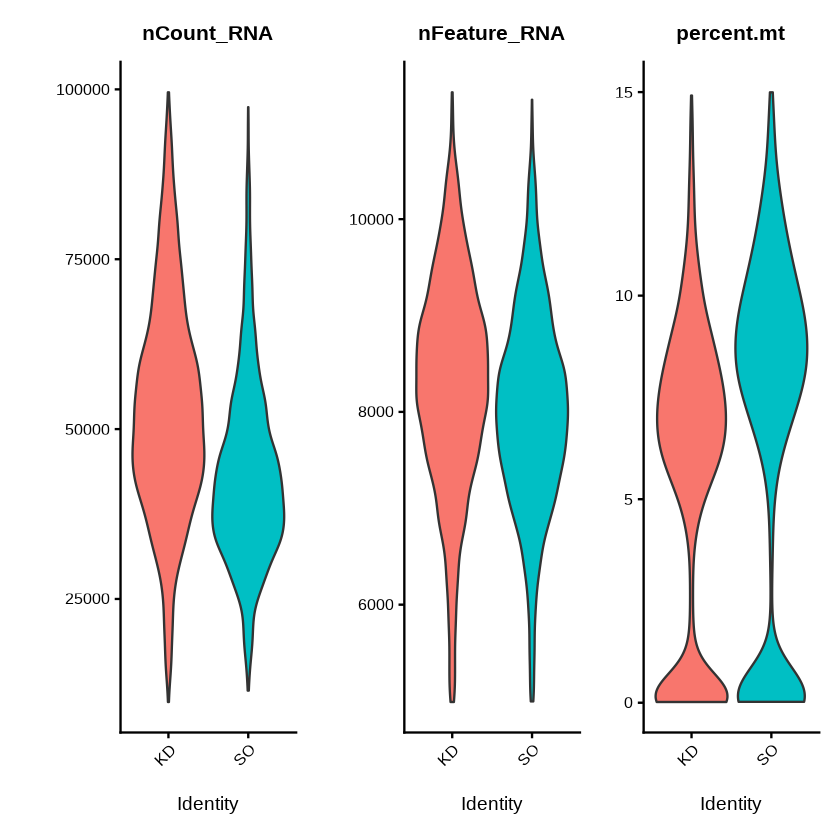

In [8]:
library(showtext)
showtext_auto()

p = VlnPlot(seurat, features = c("nCount_RNA", "nFeature_RNA", "percent.mt"),pt.size = 0, group.by = "orig.ident")
p

In [30]:
ggsave(p, file = "ASO_GeneNum_AND_UMI.pdf", height = 3, width = 6)

In [4]:
### ATF3-23680149-GBM1-GSC-HUMAN

gene = c("PLXND1;SERPINE1;PLAT;SOX3;PLAU;KIAA0895;SESN2;CAPN2;SBDSP1;PHLDA1;IFRD1;NEAT1;CCNB1IP1;GEM;RUNX1;C10ORF114;SPATA12;MALAT1;TAGLN2;TRIB3;SQSTM1;ATF3;EPHA2;CASZ1;PXN;LYPD1;TWIST1;NME1-NME2;NUAK2;C7ORF55;STC2;ZNF540;PLK3;PRNP;JUN;RPL23AP7;DTNA;GADD45B;GADD45A;PLK2;SNHG8;IFFO2;NR1D1;CORO2B;LARP6;FOSL2;FOSL1;NR4A3;MAFF;BHLHE40;GPER;SNAI1;SNAI2;MDM4;AMOTL2;CSRNP1;CDKN1A;NRP2;PRR3;HSPB8;BBC3;LETM2;RPPH1;PEA15;ANKRD1;DUSP4;KLF10;DUSP5;ANXA1;TNFRSF12A;ANXA3;SPHK1;RIPK4;PAX6;EMP3;F3;SERPINB8;DUSP6;ITPKB;PTP4A1;ZEB2;CDC42EP3;FIBIN;ANGPTL2;CDC42EP1;PLIN2;ITGA5;CHST3;PPP1R15A;CEBPB;PLEKHH3;CEBPG;PRR5L;AP3M2;C6ORF1;LMNA;SPP1;HES1;ZNF460;SMAGP;SPRY4;KLF3;NBR2;KLF5;VIM")
genes = unlist(strsplit(split = ";", gene))
head(genes)

[1] "PLXND1"   "SERPINE1" "PLAT"     "SOX3"     "PLAU"     "KIAA0895"

In [9]:
gene_list = list(ATF3_Human = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "ATF3_Human")

head(seurat@meta.data)

Warning message:
“The following features are not present in the object: SBDSP1, C10ORF114, NME1-NME2, C7ORF55, RPL23AP7, GPER, RPPH1, C6ORF1, not searching for symbol synonyms”


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.2,seurat_clusters,ATF3_Human1
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<fct>,<dbl>
SO_AAACCCAAGGACGGAG-1,SO,33962,6702,12.27689526,45806,6681,6,6,-1.814668
SO_AAACCCAAGTGTAGTA-1,SO,44794,8129,7.95249055,45920,8094,6,6,-1.295588
SO_AAACCCACATGGGTCC-1,SO,39667,7786,9.12902043,45570,7744,3,3,-1.810717
SO_AAACCCAGTAGTCCTA-1,SO,42412,8117,0.05891086,45525,8047,24,24,1.570170
SO_AAACCCAGTCTCGGAC-1,SO,55637,8834,0.06286823,48067,8766,0,0,2.855563
SO_AAACCCAGTTGGGTAG-1,SO,50431,8382,9.70439204,47962,8340,6,6,-1.586528


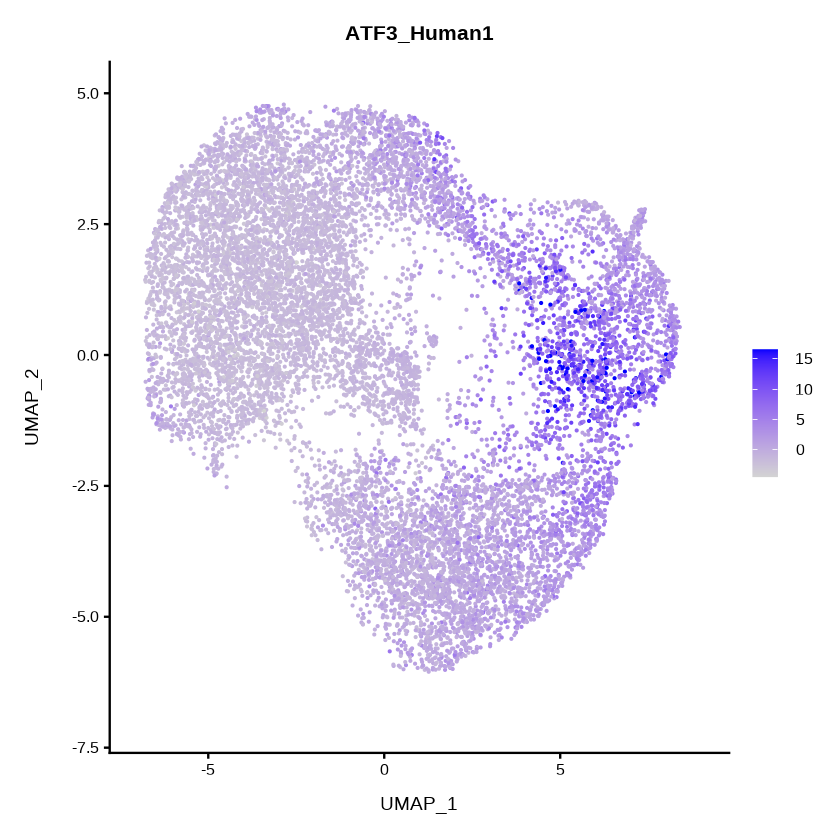

In [13]:
FeaturePlot(seurat, features = "ATF3_Human1", max.cutoff = "q99")

In [15]:
## pathway information:
#STANDARD_NAME	BIOCARTA_TID_PATHWAY
#SYSTEMATIC_NAME	M9546
#COLLECTION	C2:CP:BIOCARTA
#MSIGDB_URL	https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/BIOCARTA_TID_PATHWAY
#NAMESPACE	HUMAN_SEQ_ACCESSION
#DESCRIPTION_BRIEF	Chaperones modulate interferon Signaling Pathway
#DESCRIPTION_FULL	Signaling by interferon-gamma stimulates anti-viral responses and tumor suppression through the heterodimeric interferon-gamma receptor. Signaling is initiated by binding of interferon-gamma to its receptor, activating the receptor-associated JAK2 tyrosine kinase to phosphorylate STAT transcription factors that activate interferon responsive genes. Molecular chaperones that modulate or alter protein folding interact with different components of the interferon signaling pathway. One chaperone that modulates interferon signaling is hTid-1, a member of the DnaJ family of chaperones and a cochaperone for the heat shock protein Hsp70, another molecular chaperone. hTid-1 was found in a two-hybrid screen to bind to JAK2 and also to interact with the interferon-gamma receptor. In addition, hTid-1 and JAK2 also interact with Hsp70. Overexpression of hTid-1 represses transcriptional activation by interferon-gamma and Hsp70 dissociates from these proteins when interferon is added to cells, suggesting that Hsp70 holds Jak2 in an inactive conformation prior to ligand activation, and is released in the presence of agonist to allow the activation of Jak-2 and downstream pathways. hTid-1 and Hsp-70 interact with other signaling proteins as well. One of this is Tax, a protein encoded by the HTLV-1 virus that binds to hTid-1. hTid-1 also represses NF-kB activation by blocking the phosphorylation and inactivation of I-kappaB by the IkappaB kinase beta. Hsp70 plays a significant role in protein unfolding for entry into mitochondria and also interacts with tumor suppressor gene products to produce their anti-proliferative activity. One of the actions of interferon is to induce apoptosis of infected target cells, in part through a mitochondrial dependent mechanism. An interaction between interferon signaling and Hsp70 may alter this mitochondrial apoptosis pathway, perhaps playing a role in interferon-mediated apoptosis of infected or transformed cells. The HTLV-1 Tax protein that interacts with Hsp70 blocks mitochondrial induced apoptosis, providing a protection against interferon-mediated cellular defenses.


gene = c("HSPA1A,TP53,RB1,WT1,IFNGR1,TP53,TNF,IFNG,TNFRSF1A,TNFRSF1B,TP53,TP53,TP53,TP53,TP53,TP53,TP53,DNAJA3,RELA,NFKB1,IKBKB,WT1,WT1,TAX1BP3,IKBKB,RELA,RELA,IKBKB,NFKB1,LIN7A,JAK2,DNAJA3,HSPA1A,IFNGR2,USH1C,TAX1BP3,NFKBIA,RELA,WT1,WT1,USH1C")

genes = unique(unlist(strsplit(split = ",", gene)))

head(genes)

[1] "HSPA1A" "TP53"   "RB1"    "WT1"    "IFNGR1" "TNF"

Warning message:
“The following features are not present in the object: IFNG, not searching for symbol synonyms”


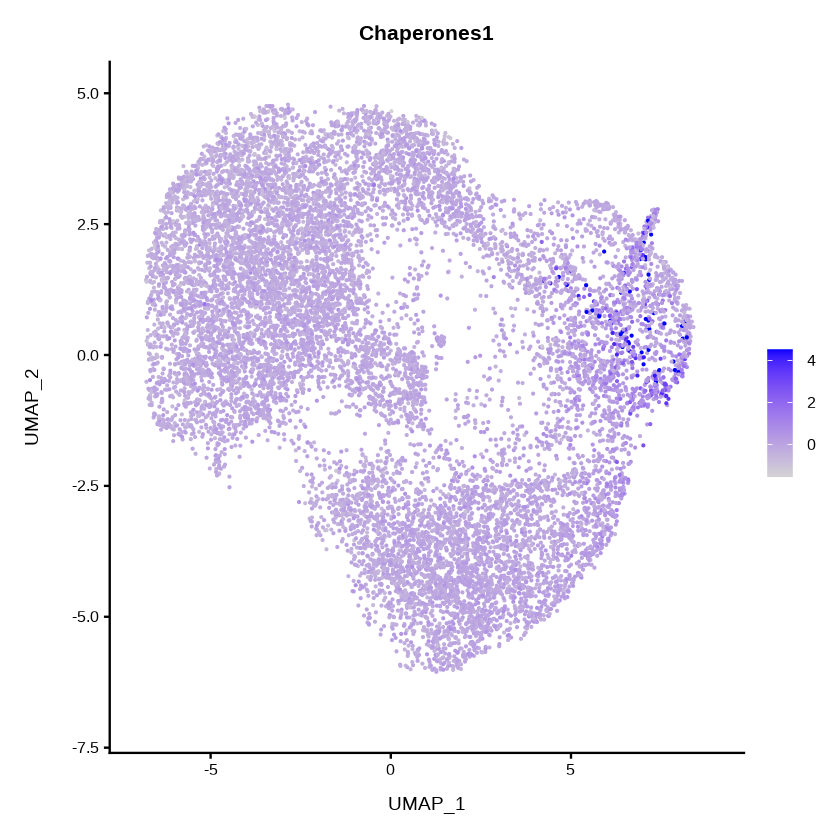

In [16]:
gene_list = list(Chaperones = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "Chaperones")

FeaturePlot(seurat, features = "Chaperones1", max.cutoff = "q99")

In [22]:
## Pathway informations
#STANDARD_NAME	IGARASHI_ATF4_TARGETS_DN
#SYSTEMATIC_NAME	M4779
#COLLECTION	C2:CGP
#MSIGDB_URL	https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/IGARASHI_ATF4_TARGETS_DN
#NAMESPACE	AFFY_HG_U133
#DESCRIPTION_BRIEF	Genes down-regulated in A549 cells (lung cancer) after knockdown of ATF4 [GeneID=468] by RNAi.
#DESCRIPTION_FULL	The mechanisms underlying cellular drug resistance have been extensively studied, but little is known about its regulation. We have previously reported that activating transcription factor 4 (ATF4) is upregulated in cisplatin-resistant cells and plays a role in cisplatin resistance. Here, we find out a novel relationship between the circadian transcription factor Clock and drug resistance. Clock drives the periodical expression of many genes that regulate hormone release, cell division, sleep-awake cycle and tumor growth. We demonstrate that ATF4 is a direct target of Clock, and that Clock is overexpressed in cisplatin-resistant cells. Furthermore, Clock expression significantly correlates with cisplatin sensitivity, and that the downregulation of either Clock or ATF4 confers sensitivity of A549 cells to cisplatin and etoposide. Notably, ATF4-overexpressing cells show multidrug resistance and marked elevation of intracellular glutathione. The microarray study reveals that genes for glutathione metabolism are generally downregulated by the knockdown of ATF4 expression. These results suggest that the Clock and ATF4 transcription system might play an important role in multidrug resistance through glutathione-dependent redox system, and also indicate that physiological potentials of Clock-controlled redox system might be important to better understand the oxidative stress-associated disorders including cancer and systemic chronotherapy.
#PMID	17297441

gene = c("DSG2,CBS,AKR1C1,TOMM20,ATF4,HSPA1A,SLC3A2,ARPC1A,SLC7A5,PHGDH,CBX1,PACSIN2,PEX19,LIPA,FAM3C,KPNA1,TRAK1,SEC24D,HSPA1B,GPX2,PCK2,ANK2,LMNB1,STC2,SKP2,CEACAM6,RPS6KA3,RAP1GAP,HSPB11,NEBL,NEBL,FZD6,S100P,SLC22A18,ASNS,ANG,APOH,PER2,DDC,KCNS3,INSL4,NCKAP1,NAB1,ASPH,AKR1C3,NAB1,SLC1A4,LEPR,ASPH,CEACAM6,CREB3L2,KIAA0232,SUCLG2,SORL1,AKT3,AKT3,RHOBTB1,DDHD2,SLC1A4,DICER1,CDK19,GNPTAB,TRIM37,CCN3,BCAT1,SUCLG2,ATP9B,SUCLG2,CCL2,EPS15,DSG2,AP5M1,OSTM1,RETREG1,WWC3,POF1B,SGK3,PSAT1,SOAT1,KLF4,VPS36,AKT3,PSAT1,OPN3,G3BP1,BCAT1,ETNK1,NEURL1B,NECTIN2,PRKAA1,CDS1,RPS6KA3,BCAT1,LINC00294,DOCK11,PRR15,TRIP12,SGMS2,TAF13,LIN7A,GPX8,SOAT1,DENND5B,TMTC2,AGR2,PGM2L1,SFXN1,ST8SIA4,GALNT4,NECTIN2,NECTIN2,VEPH1,OSTM1,OSTM1,TMTC2,FRK,SLC35B4,,SOAT1,ARRB1,ARRB1")


genes = unique(unlist(strsplit(split = ",", gene)))

head(genes)


[1] "DSG2"   "CBS"    "AKR1C1" "TOMM20" "ATF4"   "HSPA1A"

Warning message:
“The following features are not present in the object: INSL4, AGR2, , not searching for symbol synonyms”


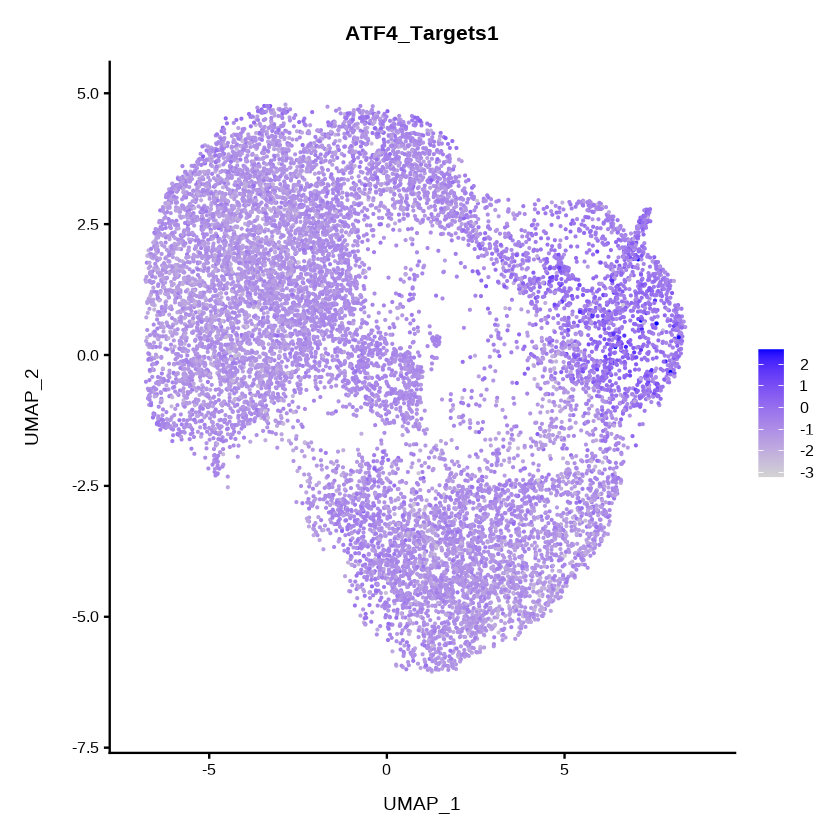

In [23]:
gene_list = list(ATF4_Targets = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "ATF4_Targets")

FeaturePlot(seurat, features = "ATF4_Targets1", max.cutoff = "q99")

In [24]:
## pathway information
#STANDARD_NAME	HALLMARK_P53_PATHWAY
#SYSTEMATIC_NAME	M5939
#COLLECTION	H
#MSIGDB_URL	https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_P53_PATHWAY
#NAMESPACE	HUMAN_GENE_SYMBOL
#DESCRIPTION_BRIEF	Genes involved in p53 pathways and networks.
#DESCRIPTION_FULL	
#PMID	26771021

gene = c("ABAT,ABCC5,ABHD4,ACVR1B,ADA,COQ8A,AEN,AK1,ALOX15B,ANKRA2,APAF1,APP,ATF3,BAIAP2,BAK1,BAX,BLCAP,BMP2,BTG1,BTG2,CASP1,CCND2,CCND3,CCNG1,CCNK,CCP110,CD81,CD82,CDH13,CDK5R1,CDKN1A,CDKN2A,CDKN2AIP,CDKN2B,CEBPA,CGRRF1,CLCA2,CSRNP2,CTSD,CTSF,CYFIP2,DCXR,DDB2,DDIT3,DDIT4,DEF6,DGKA,DNTTIP2,DRAM1,EI24,EPHA2,EPHX1,EPS8L2,ERCC5,F2R,FAM162A,FAS,FBXW7,FDXR,FGF13,FOS,FOXO3,FUCA1,GADD45A,GLS2,GM2A,RACK1,GPX2,H2AJ,HBEGF,HDAC3,HEXIM1,HINT1,H1-2,H2AC25,HMOX1,HRAS,HSPA4L,IER3,IER5,IFI30,ELP1,IL1A,INHBB,IP6K2,IRAK1,ISCU,ITGB4,JAG2,JUN,KIF13B,KLF4,KLK8,KRT17,LDHB,LIF,IRAG2,MAPKAPK3,MDM2,MKNK2,MXD1,MXD4,NDRG1,NHLH2,NINJ1,NOL8,NOTCH1,NUDT15,NUPR1,OSGIN1,PCNA,PDGFA,PERP,PHLDA3,PIDD1,PITPNC1,PLK2,PLK3,PLXNB2,PMM1,POLH,POM121,PPM1D,PPP1R15A,PRKAB1,PRMT2,PROCR,PTPN14,PTPRE,PVT1,RAB40C,RAD51C,RAD9A,RALGDS,RAP2B,RB1,RCHY1,RETSAT,RGS16,RHBDF2,RNF19B,RPL18,RPL36,RPS12,RPS27L,RRAD,RRP8,RXRA,S100A10,S100A4,SAT1,SDC1,SEC61A1,SERPINB5,SERTAD3,SESN1,SFN,SLC19A2,SLC35D1,SLC3A2,SLC7A11,SOCS1,SP1,SPHK1,ST14,STEAP3,STOM,TAP1,TAX1BP3,TCHH,TCN2,TGFA,TGFB1,TM4SF1,TM7SF3,TNFSF9,TNNI1,TOB1,TP53,TP63,TPD52L1,TPRKB,TRAF4,TRAFD1,TRIAP1,TRIB3,TSC22D1,TSPYL2,TXNIP,UPP1,VAMP8,VDR,VWA5A,WRAP73,WWP1,XPC,ZBTB16,ZFP36L1,ZMAT3,ZNF365")

genes = unique(unlist(strsplit(split = ",", gene)))

head(genes)

[1] "ABAT"   "ABCC5"  "ABHD4"  "ACVR1B" "ADA"    "COQ8A"

Warning message:
“The following features are not present in the object: CASP1, H2AJ, H1-2, H2AC25, IRAG2, not searching for symbol synonyms”


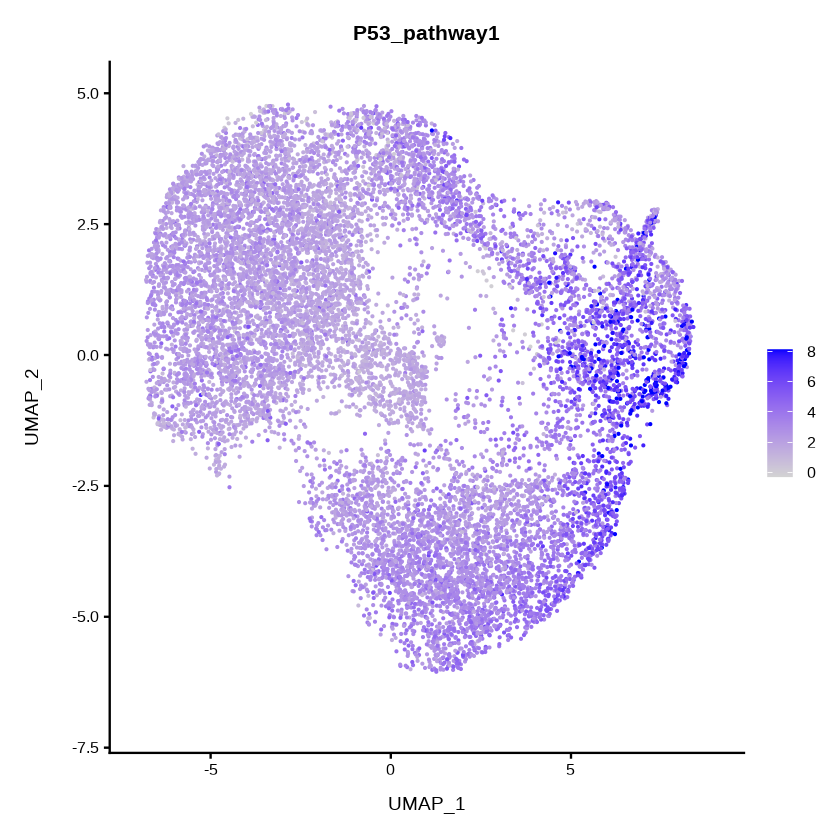

In [25]:
gene_list = list(P53 = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "P53_pathway")

FeaturePlot(seurat, features = "P53_pathway1", max.cutoff = "q99")

In [26]:
## pathway information
#STANDARD_NAME	HALLMARK_OXIDATIVE_PHOSPHORYLATION
#SYSTEMATIC_NAME	M5936
#COLLECTION	H
#MSIGDB_URL	https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_OXIDATIVE_PHOSPHORYLATION
#NAMESPACE	HUMAN_GENE_SYMBOL
#DESCRIPTION_BRIEF	Genes encoding proteins involved in oxidative phosphorylation.
#DESCRIPTION_FULL	
#PMID	26771021

gene = c("ABCB7,ACAA1,ACAA2,ACADM,ACADSB,ACADVL,ACAT1,ACO2,AFG3L2,AIFM1,ALAS1,ALDH6A1,ATP1B1,ATP5F1A,ATP5F1B,ATP5F1C,ATP5F1D,ATP5F1E,ATP5PB,ATP5MC1,ATP5MC2,ATP5MC3,ATP5PD,ATP5ME,ATP5PF,ATP5MF,ATP5MG,ATP5PO,ATP6AP1,ATP6V0B,ATP6V0C,ATP6V0E1,ATP6V1C1,ATP6V1D,ATP6V1E1,ATP6V1F,ATP6V1G1,ATP6V1H,BAX,BCKDHA,BDH2,MPC1,CASP7,COX10,COX11,COX15,COX17,COX4I1,COX5A,COX5B,COX6A1,COX6B1,COX6C,COX7A2,COX7A2L,COX7B,COX7C,COX8A,CPT1A,CS,CYB5A,CYB5R3,CYC1,CYCS,DECR1,DLAT,DLD,DLST,ECH1,ECHS1,ECI1,ETFA,ETFB,ETFDH,FDX1,FH,FXN,GLUD1,GOT2,GPI,GPX4,GRPEL1,HADHA,HADHB,HCCS,HSD17B10,HSPA9,HTRA2,IDH1,IDH2,IDH3A,IDH3B,IDH3G,IMMT,ISCA1,ISCU,LDHA,LDHB,LRPPRC,MAOB,MDH1,MDH2,MFN2,MGST3,MRPL11,MRPL15,MRPL34,MRPL35,MRPS11,MRPS12,MRPS15,MRPS22,MRPS30,MTRF1,MTRR,MTX2,NDUFA1,NDUFA2,NDUFA3,NDUFA4,NDUFA5,NDUFA6,NDUFA7,NDUFA8,NDUFA9,NDUFAB1,NDUFB1,NDUFB2,NDUFB3,NDUFB4,NDUFB5,NDUFB6,NDUFB7,NDUFB8,NDUFC1,NDUFC2,NDUFS1,NDUFS2,NDUFS3,NDUFS4,NDUFS6,NDUFS7,NDUFS8,NDUFV1,NDUFV2,NNT,NQO2,OAT,OGDH,OPA1,OXA1L,PDHA1,PDHB,PDHX,PDK4,PDP1,PHB2,PHYH,PMPCA,POLR2F,POR,PRDX3,RETSAT,RHOT1,RHOT2,SDHA,SDHB,SDHC,SDHD,SLC25A11,SLC25A12,SLC25A20,SLC25A3,SLC25A4,SLC25A5,SLC25A6,SUCLA2,SUCLG1,SUPV3L1,SURF1,TCIRG1,TIMM10,TIMM13,TIMM17A,TIMM50,TIMM8B,TIMM9,TOMM22,TOMM70,UQCR10,UQCR11,UQCRB,UQCRC1,UQCRC2,UQCRFS1,UQCRH,UQCRQ,VDAC1,VDAC2,VDAC3")

genes = unique(unlist(strsplit(split = ",", gene)))

head(genes)


[1] "ABCB7"  "ACAA1"  "ACAA2"  "ACADM"  "ACADSB" "ACADVL"

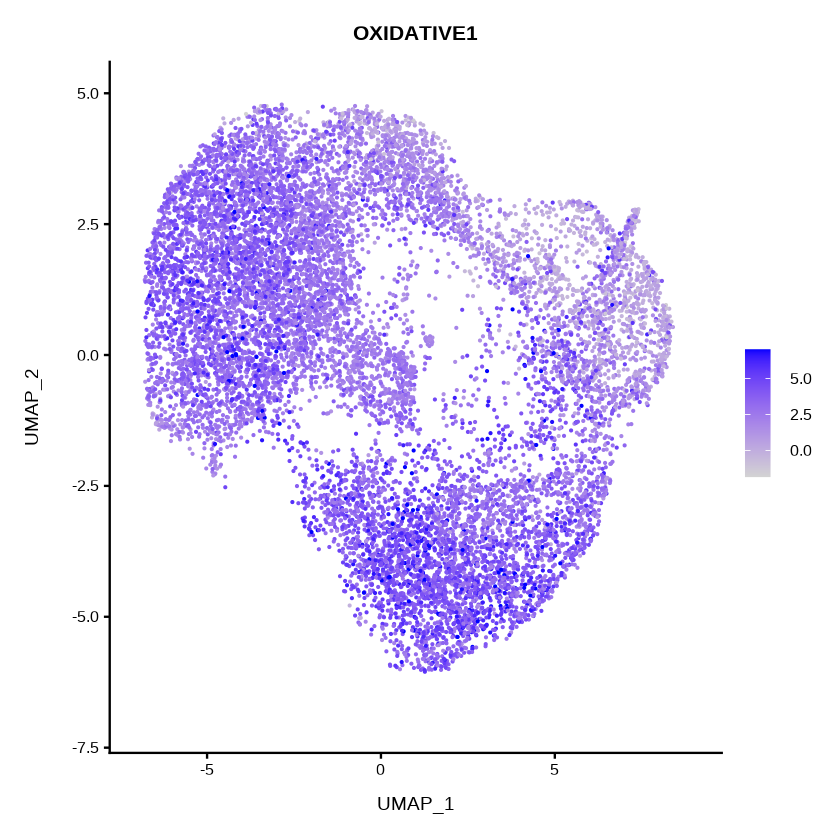

In [27]:
gene_list = list(OXIDATIVE = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "OXIDATIVE")

FeaturePlot(seurat, features = "OXIDATIVE1", max.cutoff = "q99")

In [28]:
## pathway information
#STANDARD_NAME	BUFFA_HYPOXIA_METAGENE
#SYSTEMATIC_NAME	M34030
#COLLECTION	C2:CGP
#MSIGDB_URL	https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/BUFFA_HYPOXIA_METAGENE
#NAMESPACE	AFFY_HG_U133
#DESCRIPTION_BRIEF	Common genes regulated by hypoxia across multiple head and neck and breast cancer clinical cohorts, and prognostic in multiple cancer types
#DESCRIPTION_FULL	Hypoxia is a key factor promoting solid tumour progression and resistance to therapy. Hypoxia biomarkers have the potential to predict prognosis and/or benefit from particular interventions. An approach combining knowledge of gene function and analysis of in vivo co-expression patterns was used to derive a gene expression signature of hypoxia. Specifically, previously validated hypoxia-regulated genes (seeds) were used to generate a co-expression network. To guarantee generality and robustness of this network, bootstrap was used to select genes that were consistently co-expressed with the hypoxia seeds in multiple cancers cohorts and across cancer types (three head and neck and five breast cancer clinical cohorts were used in this phase). Genes with the highest connectivity in the resulting co-expression gene network were extracted to form a hypoxia gene signature. This signature was highly enriched for hypoxia-regulated pathways, enriched for targets of the Hypoxia-Inducible Factor (HIF)-1 as determined in ChipSeq and HIF know-down experiments, and prognostic. Validation in independent data sets of head and neck, breast and lung cancer showed that this signature outperformed previously reported hypoxia gene signatures.
#PMID	20087356

gene = c("NDRG1,LDHA,PGK1,TPI1,PGAM1,PFKP,ENO1,SLC2A1,PNP,BNIP3,PSRC1,SLC16A1,DDIT4,ADM,HK2,SEC61G,AK4,CA9,P4HA1,ACOT7,GPI,TUBB6,TUBA1C,CDKN3,CTSV,VEGFA,TUBA1A,LRRC42,PSMA7,GAPDH,CHCHD2,YKT6,MIF,MAP7D1,MRPL15,MRPL13,MCTS1,UTP11,KIF4A,HILPDA,MRGBP,KIF20A,MRPS17,ESRP1,SHCBP1,SLC25A32,CORO1C,ANLN,MAD2L2,ANKRD37,")
genes = unique(unlist(strsplit(split = ",", gene)))

head(genes)



[1] "NDRG1" "LDHA"  "PGK1"  "TPI1"  "PGAM1" "PFKP"

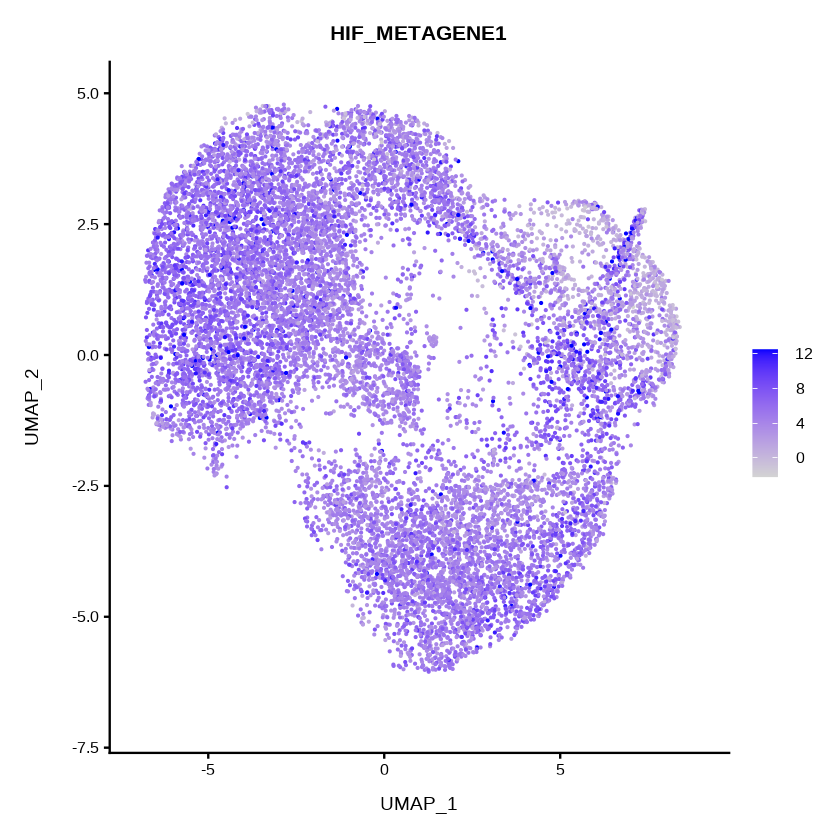

In [29]:
gene_list = list(HIF = genes)
seurat = AddModuleScore(seurat, features =gene_list, name = "HIF_METAGENE")

FeaturePlot(seurat, features = "HIF_METAGENE1", max.cutoff = "q99")